In [234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

pd.set_option("display.width", None)
pd.set_option("display.max_columns", None)


#    I will be working on new_york_city dataset, which conatains data of bike rental busines.
# I'm going ot exlore dataset, perform essential data cleaning, try to extract usefull information and visualize it.


bikes_data = pd.read_csv("Data/new_york_city.csv", parse_dates=True)
print(bikes_data.head())
bikes_data.info()

   Unnamed: 0           Start Time             End Time  Trip Duration  \
0     5688089  2017-06-11 14:55:05  2017-06-11 15:08:21            795   
1     4096714  2017-05-11 15:30:11  2017-05-11 15:41:43            692   
2     2173887  2017-03-29 13:26:26  2017-03-29 13:48:31           1325   
3     3945638  2017-05-08 19:47:18  2017-05-08 19:59:01            703   
4     6208972  2017-06-21 07:49:16  2017-06-21 07:54:46            329   

             Start Station             End Station   User Type  Gender  \
0  Suffolk St & Stanton St  W Broadway & Spring St  Subscriber    Male   
1  Lexington Ave & E 63 St         1 Ave & E 78 St  Subscriber    Male   
2        1 Pl & Clinton St    Henry St & Degraw St  Subscriber    Male   
3    Barrow St & Hudson St         W 20 St & 8 Ave  Subscriber  Female   
4          1 Ave & E 44 St         E 53 St & 3 Ave  Subscriber    Male   

   Birth Year  
0      1998.0  
1      1981.0  
2      1987.0  
3      1986.0  
4      1992.0  
<class 'pandas

In [235]:
#    I start with converting dates from strings (objects) to datetime type, renaming unnamed columns, removing 
#rows with missing values (i can afford deleting some rows, becuase there is still plenty more data left), 
#replacing some values with shorter labels.


bikes_data["Start Time"] = pd.to_datetime(bikes_data["Start Time"])
bikes_data["End Time"] = pd.to_datetime(bikes_data["End Time"])

print(bikes_data['Start Time'].max() - bikes_data['Start Time'].min())
print(len(bikes_data["Unnamed: 0"].unique()))

# There are 300 thousand observations from almost 181 days.

bikes_data = bikes_data.rename(columns = {"Unnamed: 0": "ID"})
bikes_data = bikes_data.dropna(subset = ["User Type", "Birth Year", "Gender"])
print(bikes_data.info())

print(bikes_data["User Type"].unique())
bikes_data["User Type"] = bikes_data["User Type"].replace({"Subscriber": "S", "Customer": "C"})


180 days 23:39:10
300000
<class 'pandas.core.frame.DataFrame'>
Int64Index: 270102 entries, 0 to 299999
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   ID             270102 non-null  int64         
 1   Start Time     270102 non-null  datetime64[ns]
 2   End Time       270102 non-null  datetime64[ns]
 3   Trip Duration  270102 non-null  int64         
 4   Start Station  270102 non-null  object        
 5   End Station    270102 non-null  object        
 6   User Type      270102 non-null  object        
 7   Gender         270102 non-null  object        
 8   Birth Year     270102 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(2), object(4)
memory usage: 20.6+ MB
None
['Subscriber' 'Customer']


In [231]:
bikes_data["Age"] = datetime.datetime.now().year - bikes_data["Birth Year"]

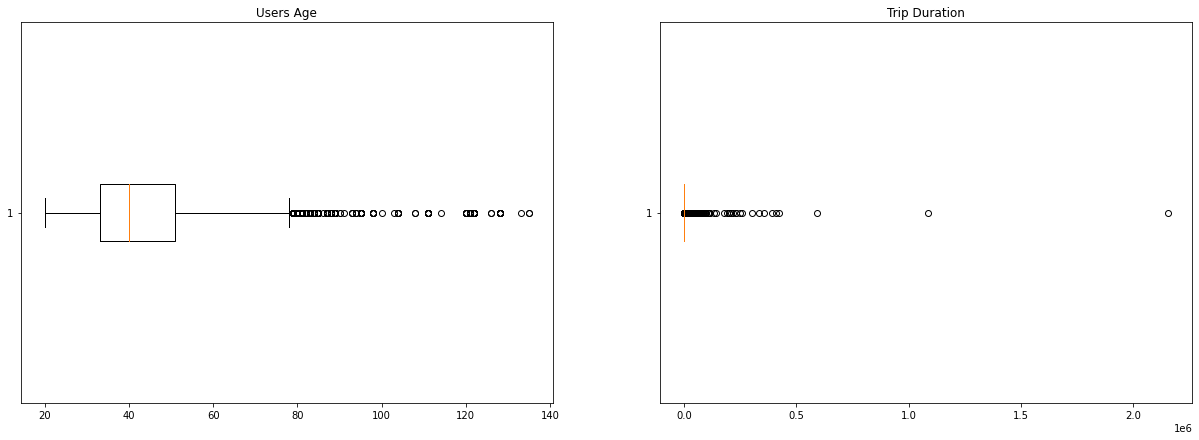

In [224]:
def age_duration_plots():
    fig, axs = plt.subplots(1, 2, figsize=(21, 7))
    axs[0].boxplot(bikes_data["Age"], vert=False)
    axs[0].set_title("Users Age")

    axs[1].boxplot(bikes_data["Trip Duration"], vert=False)
    axs[1].set_title("Trip Duration")

age_duration_plots()

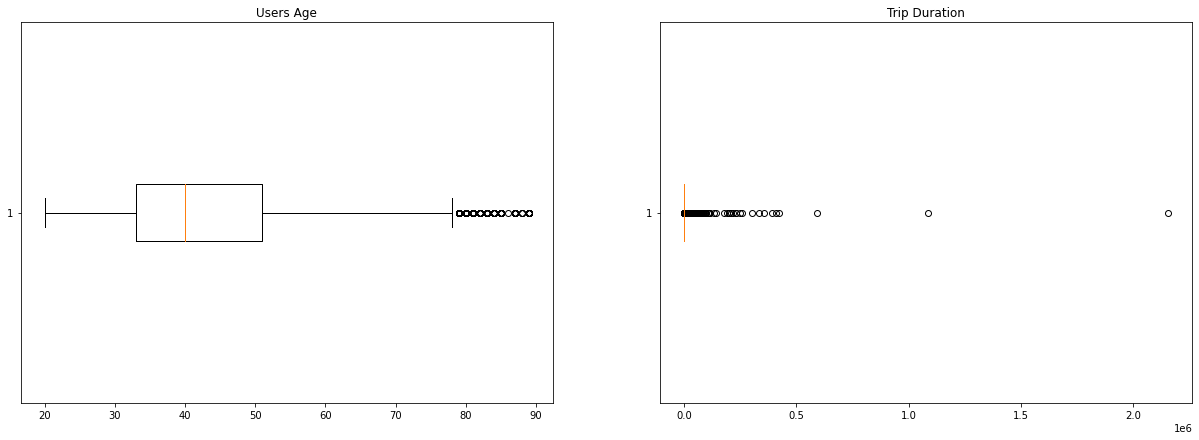

In [225]:

# We can clearly see outliers in both groups (Users Age and Trip Duration)
#    Only about 0.5% of worlds population is older than 90 years. In this particular case considering our data 
# is about users who ride bikes, we can assume that every observation with age greater than 90 years old is incorrect
# and we can get rid of it.

bikes_data = bikes_data[bikes_data["Age"] < 90]
age_duration_plots()

32


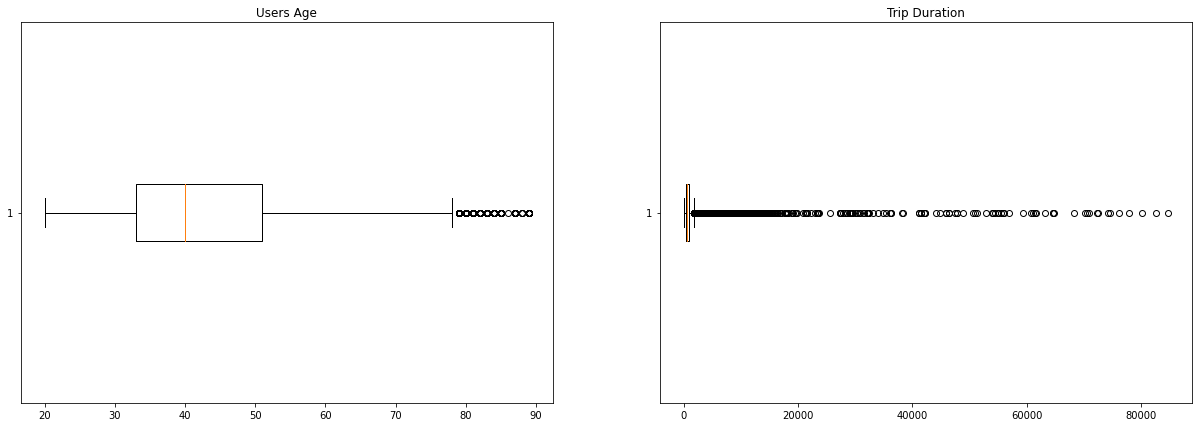

In [226]:

#    Let's get into Trip Durations, max value is over 2000000 second, which translates to 611 hours or 25.4 days!
# We assume that realistcly our clients, don't rent bikes for more then 24 hours at once. 

print(sum(bikes_data['Trip Duration'] > 86400))

# There are only 32 observations that exceed the 24 hour mark, there are still about 27 thousand more observations.
# Therefore we can drop this 32 rows without greater consequences.

bikes_data = bikes_data[bikes_data['Trip Duration'] < 86400]
age_duration_plots()

# However ther are still a lot of outliers

0.900    1491.000
0.995    3215.000
0.999    9412.666
Name: Trip Duration, dtype: float64
(270, 10)
(269700, 10)


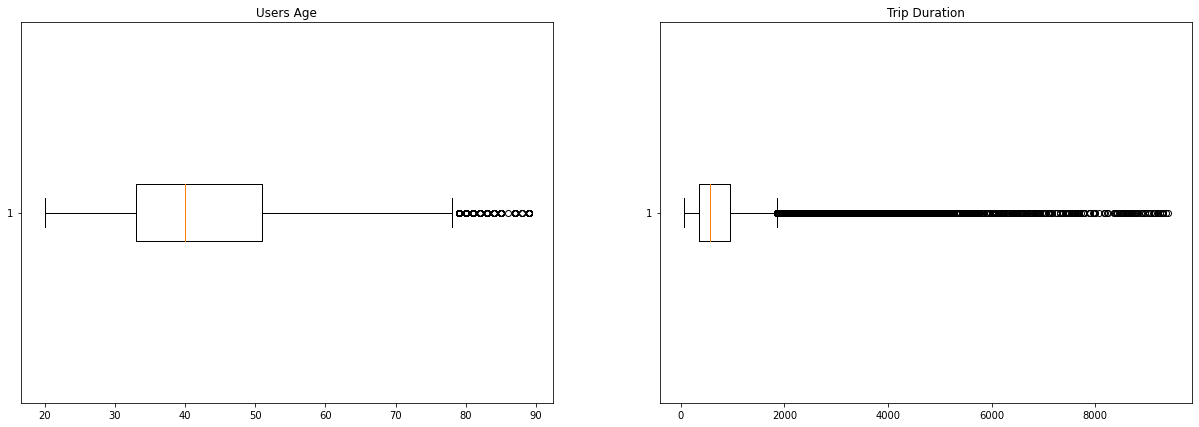

In [229]:
top90 = bikes_data['Trip Duration'].quantile(q=[0.99, 0.995, 0.999])
print(top999)
# Calculated qunatiles indacete that only 0.5% observations exceed ~53 miutes (3215 seconds), and only 0.1% trips
# lasts more then 2 hours 36 minutes (9413 seconds)

over_2_36 = bikes_data[bikes_data['Trip Duration'] > 9413]
print(over_2_36.shape)

# The 0.01% is 270 observations, wich we have to keep in mind. However in oreder to create
# non-biased and accurate model we should drop them.

bikes_data = bikes_data[bikes_data['Trip Duration'] < 9413]
print(bikes_data.shape)
age_duration_plots()



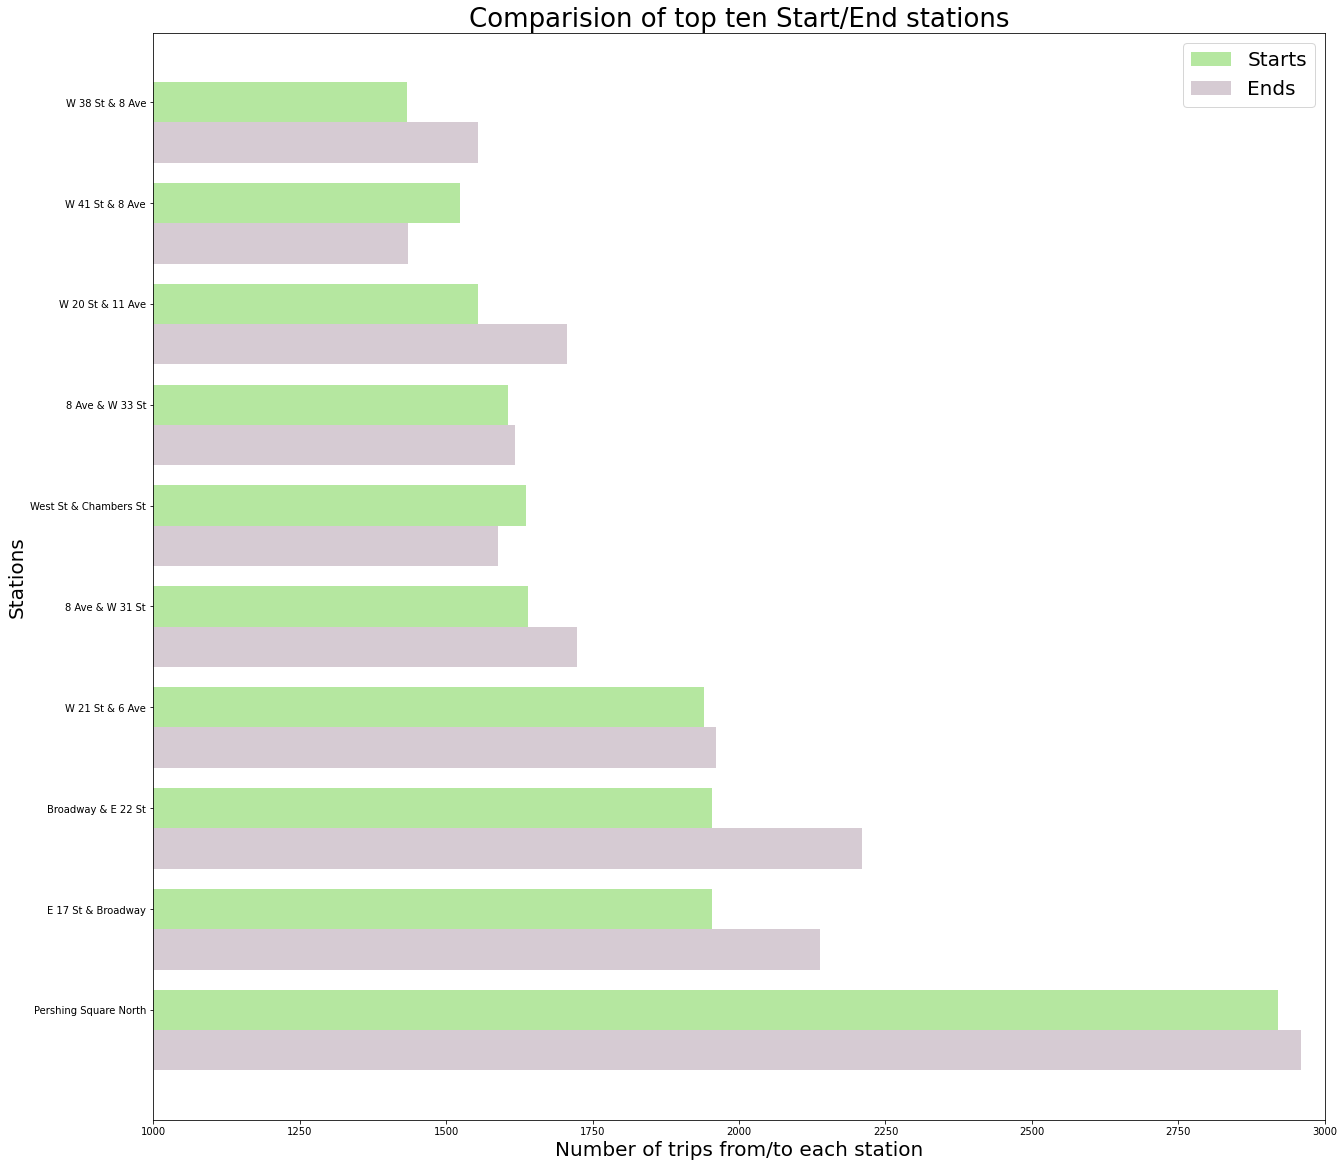

In [137]:
#    Now let's explore how many bikes are taken/left on each of top ten starting locations. Stations on which grey 
# bar exceeds green bar indicate that there are more bikes left than taken. (In real life situation this
# would mean that our business has to remove redundant bikes from there)
#    Accordingly, these stations where green bar exceeds grey, have not enough bikes. We would have to deliver 
# additional bikes to these locations in oreder to keep them functioning.

fig1, axs1 = plt.subplots(1, 1, figsize=(21,20))

top_ten_starts = bikes_data["Start Station"].value_counts()[:10]
top_ten_ends = bikes_data["End Station"].value_counts().loc[top_ten_starts.index]
top_ten = pd.DataFrame({"Start": top_ten_starts, "End": top_ten_ends})


# plot
X = top_ten.index
Y_starts = top_ten["Start"]
Y_ends = top_ten["End"]

x_axis = np.arange(len(X))

axs1.barh(x_axis + 0.2, Y_starts, 0.4, label="Starts", tick_label=X, color="#b5e7a0")
axs1.barh(x_axis - 0.2, Y_ends, 0.4, label="Ends", color="#d6cbd3")
axs1.set_xlim(1000,3000)
axs1.set_ylabel("Stations", fontsize=20)
axs1.set_xlabel("Number of trips from/to each station", fontsize=20)
axs1.set_title("Comparision of top ten Start/End stations", fontsize=26)
axs1.legend(fontsize=20)



Gender
Male      203535
Female     66567
dtype: int64


<AxesSubplot:title={'center':'User Type'}>

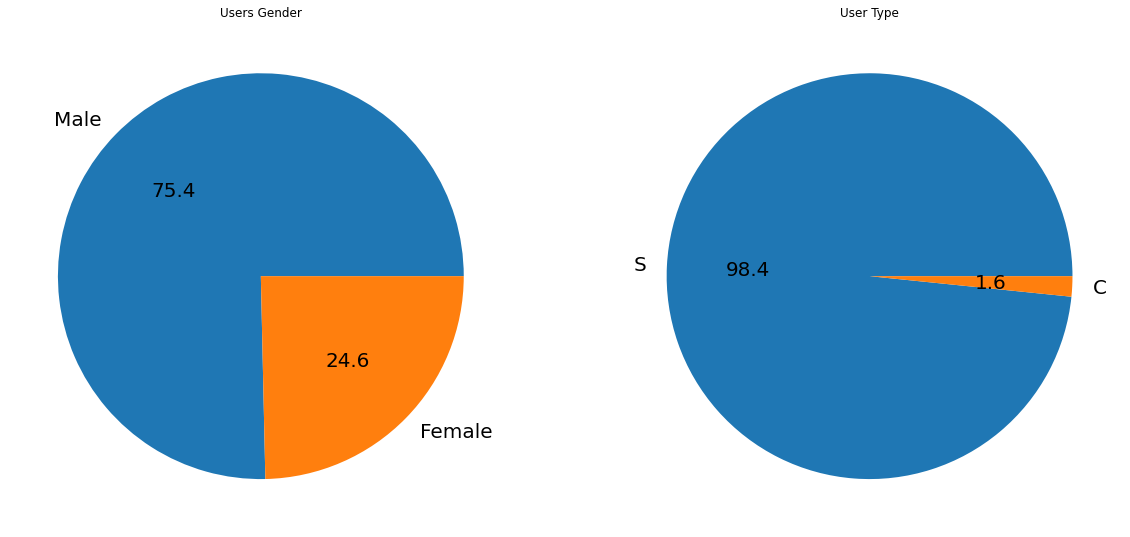

In [156]:

#    As much as 98.4% of our customers are Subscribers, and the remaining 1.6% are ordinary Customers
# It states that we as company should care, and target Subsribers because they're majority of our users.
#    Only 1/4 of our users are Women, there is a lot of room for improvement in this area, we should
# definitely take it into considaration. Try to become more "women frinedly".

fig2, axs2 = plt.subplots(1, 2, figsize=(20, 10))

gender_data = bikes_data.value_counts("Gender")
print(gender_data)
gender_data.plot(ax=axs2[0], 
                 kind='pie', 
                 title="Users Gender", 
                 labels=gender_data.index, 
                 autopct="%.1f", 
                 fontsize=20, 
                 ylabel="")

usertype_data = bikes_data["User Type"].value_counts()
usertype_data.plot(ax=axs2[1], 
                   kind='pie', 
                   title="User Type",
                   labels=usertype_data.index, 
                   autopct="%.1f", 
                   fontsize=20,
                   ylabel="",
                   )